In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from scripts.filter_utils import *
import re

# Generate saved tables

In [45]:
experiment_table, sample_df, replicate_df = load_experiment_manifest()
samples = experiment_table['sample'].tolist()
codon_order = ['ATG', 'ATA', 'ATC', 'ATT', 'ACG', 'AAG', 'AGG', 'GTG', 'TTG', 'CTG']

In [4]:
def load_gtf_annotations(gtf_path=GTF_FILE, features=['start_codon', 'CDS', 'UTR']):
    annotation_tables = []
    if isinstance(features, str):
        features = [features]
    for feature in features:
        print(f'Reading {feature}s from {gtf_path}')
        annotation_tables.append(load_transcript_annotations(gtf_path=gtf_path, feature_type=feature))
    if len(annotation_tables) == 1:
        return annotation_tables[0]
    else:
        return annotation_tables

gtf_annotations = load_gtf_annotations()
start_codon_annotations, cds_annotations, utr_annotations = gtf_annotations

Reading start_codons from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading CDSs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading UTRs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf


In [5]:
transcript_to_genome_pos = get_canonical_genome_positions(cds_annotations=cds_annotations)
transcript_to_utr_length = get_utr_lengths(cds_annotations=cds_annotations, utr_annotations=utr_annotations)
transcript_to_start_codon = get_start_codons(start_codon_annotations=start_codon_annotations, genome_file=GENOME_FILE)
transcript_to_protein = get_protein_products(protein_fasta=PROTEIN_FASTA)

100%|██████████| 221201/221201 [02:07<00:00, 1735.32it/s]


Reading protein sequences from /lab/barcheese01/smaffa/coTISja/data/reference/gencode.v49.pc_translations.fa


In [9]:
LOAD_SEQUENCES = True
sequences = ['AASeq'] #['Seq', 'AASeq']

sample_to_filtered_tis = dict()

for sample in tqdm(samples):
    filt_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'filtered_file'])

    # add undetected canonical start codons
    imputed_table = impute_missing_canonical_starts(
        filt_table, 
        genome_pos=transcript_to_genome_pos, 
        utr_lengths=transcript_to_utr_length, 
        start_codons=transcript_to_start_codon,
        protein_products=transcript_to_protein
    )

    # combine with the detected TISs
    filt_table = pd.concat([
        filt_table, imputed_table
    ], axis=0, ignore_index=True)
    filt_table['Imputed'] = filt_table['Imputed'].fillna(False)

    if LOAD_SEQUENCES:
        pred_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'predict_file'], sep='\t', usecols=['Tid', 'GenomePos', 'Start'] + sequences)
        # pull AA translations for the non-canonical TISs from the ribotish outputs
        merged_table = filt_table.merge(pred_table, left_on=['Tid', 'GenomePos', 'Start'], right_on=['Tid', 'GenomePos', 'Start'], how='left')

        # pull AA translations for the canonical TISs from the protein annotations
        merged_table.loc[
            merged_table['Imputed'], 'AASeq'
        ] = transcript_to_protein.set_index('Tid').reindex(
            index=merged_table[merged_table['Imputed']]['Tid'].tolist()
        )['AASeq'].tolist()
    else:
        merged_table = filt_table
    sample_to_filtered_tis[sample] = merged_table
all_tis_df= pd.concat(sample_to_filtered_tis, axis=0).reset_index(names=['Sample', 'drop']).drop(['drop'], axis=1)

100%|██████████| 6/6 [00:52<00:00,  8.68s/it]


In [141]:
sample_normalization_factors = pd.Series(
    {s: tmm_normalization_factors(s, 'HeLa') for s in samples}, name='SampleScaleFactor'
)
sample_normalization_factors.index.name = 'Sample'
all_tis_df = all_tis_df.merge(sample_normalization_factors, left_on='Sample', right_index=True)

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log

In [142]:
all_tis_df['IsoformID'] = all_tis_df['Tid'] + ':' + all_tis_df['Start'].astype(int).astype(str)
all_tis_df['TIS_ID'] = all_tis_df['Gid'] + ':' + all_tis_df['GenomeStart']
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
tis_annotation_df = all_tis_df[['TIS_ID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()

In [144]:
all_tis_df[all_tis_df['MANE_Select']].to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_mane_only.csv', index=False)
all_tis_df.drop(['AASeq'], axis=1).to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered.csv', index=False)
all_tis_df.to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv', index=False)

In [182]:
paired_isoform_df = all_tis_df[~all_tis_df['RecatTISType'].isin(['Annotated'])].drop_duplicates(subset=['Sample', 'IsoformID']).merge(
    all_tis_df[all_tis_df['RecatTISType'].isin(['Annotated'])].drop_duplicates(subset=['Sample', 'Tid'])[
        ['Sample', 'IsoformID', 'Tid', 'Start', 'StartCodon', 'TISCounts', 'NormTISCounts']
    ].rename({
        'IsoformID': 'CanonicalIsoformID', 'Start':'CanonicalStart', 
        'StartCodon':'CanonicalStartCodon', 'TISCounts':'CanonicalTISCounts', 
        'NormTISCounts':'CanonicalNormTISCounts'}, axis=1),
    how='left'
).dropna(subset=['CanonicalIsoformID', 'CanonicalStart', 'CanonicalStartCodon', 'CanonicalTISCounts', 'CanonicalNormTISCounts'])
paired_isoform_df['FoldChangeFromCanonical'] = (paired_isoform_df['TISCounts']+1) / (paired_isoform_df['CanonicalTISCounts']+1)
paired_isoform_df['LogFoldChangeFromCanonical'] = np.log2(paired_isoform_df['FoldChangeFromCanonical'])
paired_isoform_df['DistanceToCanonical'] = (paired_isoform_df['CanonicalStart'] - paired_isoform_df['Start']).abs()
paired_isoform_df = paired_isoform_df.assign(
    SampleNormalizedLFC = lambda x: np.log2(((x['TISCounts'] * x['SampleScaleFactor']) + 1) / ((x['CanonicalTISCounts'] * x['SampleScaleFactor']) + 1))
)
paired_isoform_df.to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_paired_tis.csv', index=False)

## Load from saved files

In [183]:
all_tis_df = pd.read_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv')
paired_isoform_df = pd.read_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_paired_tis.csv')
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
genomic_tis_annotation_df = all_tis_df[['TIS_ID', 'Symbol', 'StartCodon']].drop_duplicates()
gene_annotation_df = all_tis_df[['Gid', 'Symbol']].drop_duplicates()

isoform_to_tis = all_tis_df[['IsoformID', 'TIS_ID']].drop_duplicates()
isoform_to_gene = all_tis_df[['IsoformID', 'Gid']].drop_duplicates()
tis_to_gene = all_tis_df[['TIS_ID', 'Gid']].drop_duplicates()
gene_to_symbol = all_tis_df[['Gid', 'Symbol']].drop_duplicates()

In [184]:
mane_select_tis_df = all_tis_df[all_tis_df['MANE_Select']]
mane_select_paired_tis_df = paired_isoform_df[paired_isoform_df['MANE_Select']]

# Stringency

## Relative usage of CUG to AUG

Text(0.5, 1.0, 'Relative CUG / canonical AUG usage per transcript')

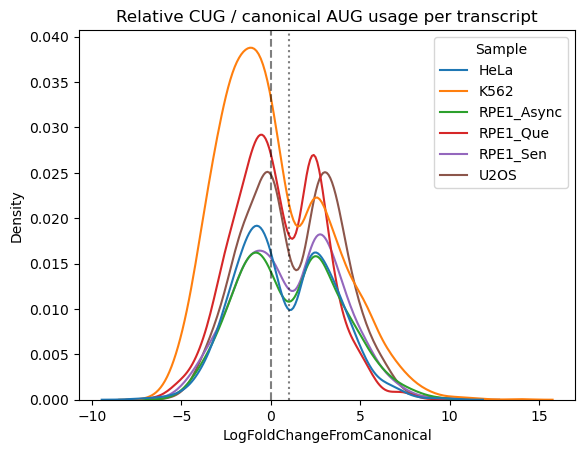

In [13]:
sns.kdeplot(
    mane_select_paired_tis_df[mane_select_paired_tis_df['StartCodon'] == 'CTG'],
    hue='Sample',
    x='LogFoldChangeFromCanonical'
)
plt.axvline(0, linestyle='dashed', color='black', alpha=0.5)
plt.axvline(1, linestyle='dotted', color='black', alpha=0.5)
plt.title('Relative CUG / canonical AUG usage per transcript')

Text(0.5, 1.0, 'Relative upstream CUG / canonical AUG usage per transcript')

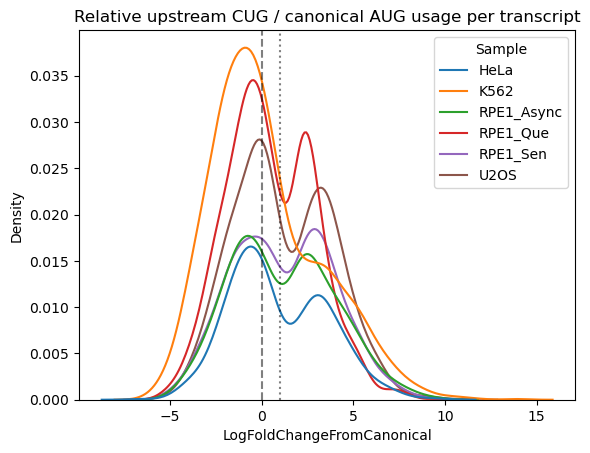

In [14]:
sns.kdeplot(
    mane_select_paired_tis_df[(mane_select_paired_tis_df['StartCodon'] == 'CTG') & 
                              (mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']))],
    hue='Sample',
    x='LogFoldChangeFromCanonical'
)
plt.axvline(0, linestyle='dashed', color='black', alpha=0.5)
plt.axvline(1, linestyle='dotted', color='black', alpha=0.5)
plt.title('Relative upstream CUG / canonical AUG usage per transcript')

0 signifies equal reads from upstream CUG and canonical AUG; less than 0 signifies more translation from the canonical start site; greater than 0 signfies more translation from the upstream CUG. 

There is a larger probability mass around slightly less than 0, and a longer tail on the positive end, which suggests that most transcript experience primarily canonical translation, but the ones that have upstream translation have strong translation initiation at those sites. If we were to design an supervised learning algorithm to predict translation efficiency/usage, I would use the larger mode as positive examples and the smaller mode + in-frame extension TISs without reads as negative examples.

What explains why this isn't symmetic around 0? Maybe because examples of (upstream/annotated) are included if upstream is sufficiently high in readcounts, but examples where upstream is not sufficiently high aren't reported by ribotish filtering (e.g. we have no instances of (0/10) but we have instances of (10/0))

Good to see that there is nothing special about 1 - it is only artifactual that 1 appears to be the breakpoint between modes when plotted over TIS all categories

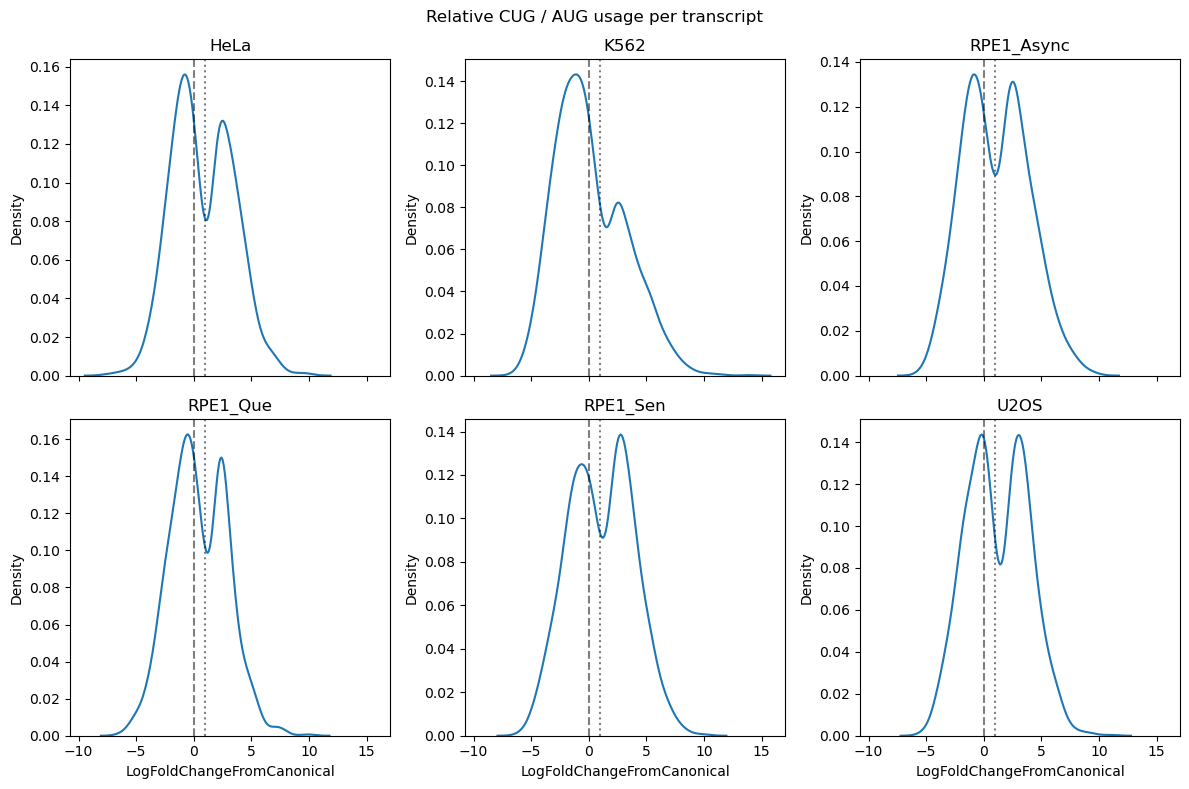

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.kdeplot(
        mane_select_paired_tis_df[
            (mane_select_paired_tis_df['StartCodon'] == 'CTG') & 
            # (mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])) &
            (mane_select_paired_tis_df['Sample'] == s)
            ],
        x='LogFoldChangeFromCanonical',
        ax=axs[i]
    )
    axs[i].axvline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].axvline(1, linestyle='dotted', color='black', alpha=0.5)
    axs[i].set_title(s)

plt.suptitle('Relative CUG / AUG usage per transcript')
plt.tight_layout()
plt.show()

This suggests that detected truncations are biased towards higher translation than their canonical sites, compared to extensions. (To whatever extent ribotish is capturing putative aTISs. Hard to make broad generalizations because we are analyzing over only transcripts with a detected aTIS).

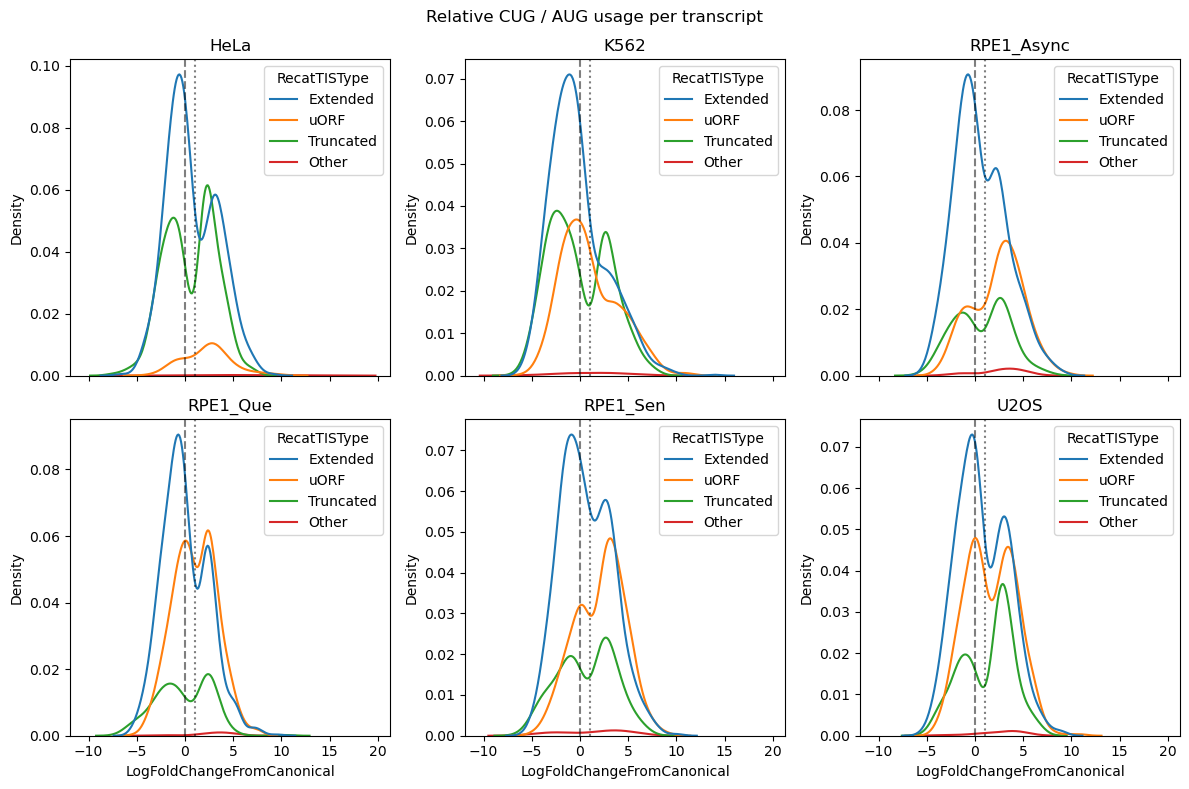

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.kdeplot(
        mane_select_paired_tis_df[
            (mane_select_paired_tis_df['StartCodon'] == 'CTG') & 
            # (mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])) &
            (mane_select_paired_tis_df['Sample'] == s)
            ],
        hue='RecatTISType', hue_order=['Extended', 'uORF', 'Truncated', 'Other'],
        x='LogFoldChangeFromCanonical',
        ax=axs[i]
    )
    axs[i].axvline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].axvline(1, linestyle='dotted', color='black', alpha=0.5)
    axs[i].set_title(s)

plt.suptitle('Relative CUG / AUG usage per transcript')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Upstream codon usage foldchanges')

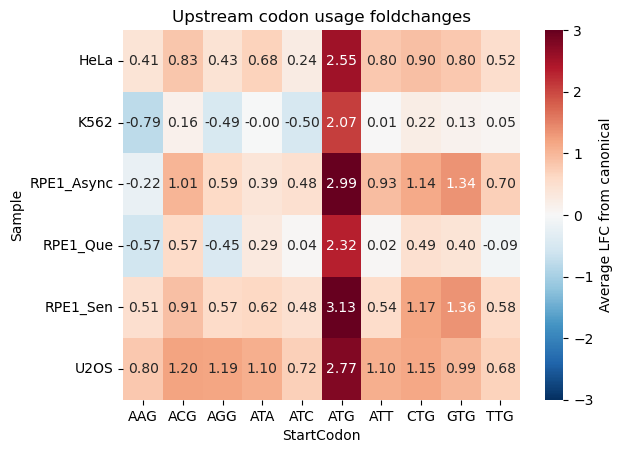

In [21]:
sns.heatmap(
    mane_select_paired_tis_df[mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])].pivot_table(
        index='Sample', columns='StartCodon', values='LogFoldChangeFromCanonical', aggfunc='mean'
    ), cmap='RdBu_r', vmin=-3, vmax=3, annot=True, fmt='.2f', cbar_kws={'label': 'Average LFC from canonical'}
)
plt.title('Upstream codon usage foldchanges')

NOTE: ONLY COMPARE ABOVE ACROSS CODONS, NOT SAMPLES. 

Currently this cannot be compared across cell lines, because individual transcripts have not been adjusted for relative differences in transcript abundance. The fairest comparison is to normalize each transcript as if it had the same transcript abundance in each cell line

In [37]:
mane_select_paired_tis_df.columns

Index(['Sample', 'Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos',
       'GenomeStart', 'Start', 'StartCodon', 'TisType', 'RecatTISType',
       'TISGroup', 'TISCounts', 'NormTISCounts', 'GeneRNASeqCounts',
       'TotalRNASeqCounts', 'AALen', 'MANE_Select', 'transcript_support_level',
       'Imputed', 'AASeq', 'IsoformID', 'TIS_ID', 'CanonicalIsoformID',
       'CanonicalStart', 'CanonicalStartCodon', 'CanonicalTISCounts',
       'CanonicalNormTISCounts', 'FoldChangeFromCanonical',
       'LogFoldChangeFromCanonical', 'DistanceToCanonical'],
      dtype='str')

In [168]:
mane_select_paired_tis_df = mane_select_paired_tis_df.assign(
    SampleNormalizedLFC = lambda x: np.log2(((x['TISCounts'] * x['SampleScaleFactor']) + 1) / ((x['CanonicalTISCounts'] * x['SampleScaleFactor']) + 1))
)

Text(0.5, 1.0, 'Upstream codon usage foldchanges')

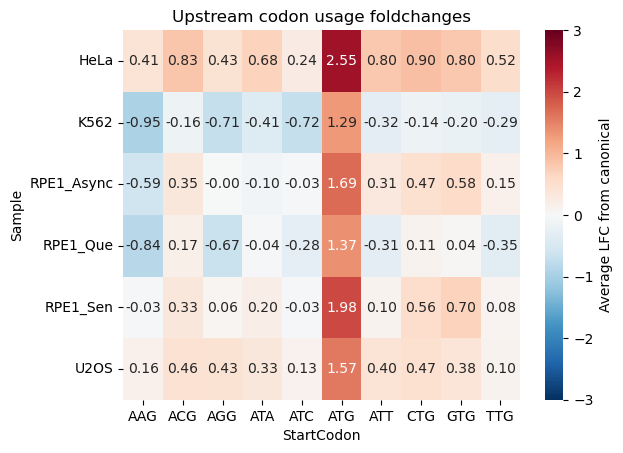

In [170]:
sns.heatmap(
    mane_select_paired_tis_df[mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])].pivot_table(
        index='Sample', columns='StartCodon', values='SampleNormalizedLFC', aggfunc='mean'
    ), cmap='RdBu_r', vmin=-3, vmax=3, annot=True, fmt='.2f', cbar_kws={'label': 'Average LFC from canonical'}
)
plt.title('Upstream codon usage foldchanges')

In [153]:
noncanonical_tis_counts = mane_select_paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='TISCounts').fillna(0)
canonical_tis_counts = mane_select_paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='CanonicalTISCounts').fillna(0)
rnaseq_abundance = mane_select_paired_tis_df.pivot_table(index='Sample', columns='IsoformID', values='GeneRNASeqCounts').fillna(0)

<Axes: xlabel='Mean_CUG_over_AUG', ylabel='Riboseq_CTG_over_ATG'>

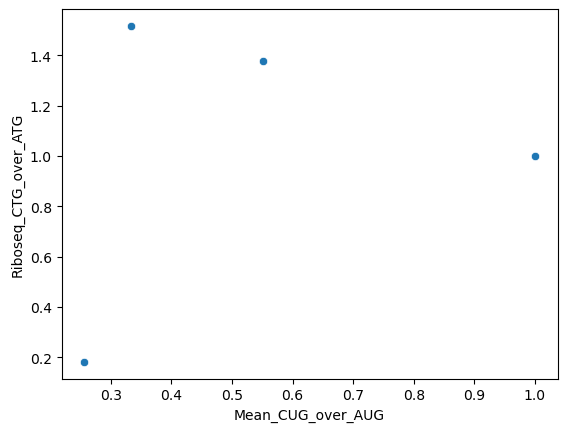

In [23]:
stringency_table = pd.read_csv('/lab/barcheese01/aTIS_data/stringency/CUG_AUG_stringency_16celllines.csv')

relative_cug_aug = mane_select_paired_tis_df[
    (mane_select_paired_tis_df['StartCodon'] == 'CTG')
].groupby('Sample')['LogFoldChangeFromCanonical'].mean()
relative_cug_aug = relative_cug_aug / relative_cug_aug.loc['HeLa']
relative_cug_aug = pd.DataFrame(relative_cug_aug.rename('Riboseq_CTG_over_ATG'))

stringency_df = stringency_table.merge(
    relative_cug_aug.rename({'RPE1_Async': 'RPE1'}), left_on='Cell_line', right_index=True
)

sns.scatterplot(stringency_df, x='Mean_CUG_over_AUG', y='Riboseq_CTG_over_ATG')

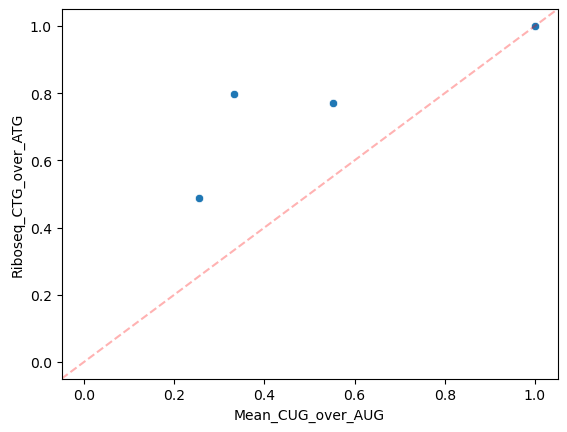

In [176]:
stringency_table = pd.read_csv('/lab/barcheese01/aTIS_data/stringency/CUG_AUG_stringency_16celllines.csv')

relative_cug_aug = mane_select_paired_tis_df[
    (mane_select_paired_tis_df['StartCodon'] == 'CTG')
].groupby('Sample')['SampleNormalizedLFC'].mean()
relative_cug_aug = 2 ** relative_cug_aug
relative_cug_aug = relative_cug_aug / relative_cug_aug.loc['HeLa']
relative_cug_aug = pd.DataFrame(relative_cug_aug.rename('Riboseq_CTG_over_ATG'))

stringency_df = stringency_table.merge(
    relative_cug_aug.rename({'RPE1_Async': 'RPE1'}), left_on='Cell_line', right_index=True
)

sns.scatterplot(stringency_df, x='Mean_CUG_over_AUG', y='Riboseq_CTG_over_ATG')
plt.gca().axline((0, 0), slope=1, linestyle='dashed', color='red', alpha=0.3)

# Relative translation conditional on upstream start codon

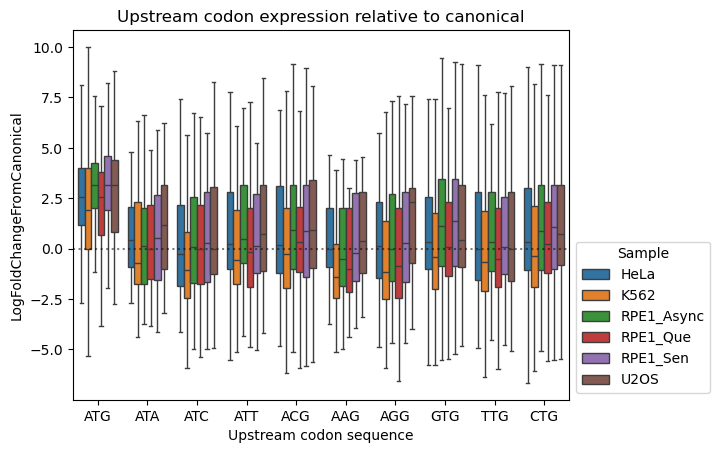

In [180]:
sns.boxplot(
    mane_select_paired_tis_df[mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='StartCodon', y='LogFoldChangeFromCanonical', hue='Sample', showfliers=False,
    order=codon_order
)
plt.gca().axhline(0, linestyle='dotted', color='black', alpha=0.5)
plt.title('Upstream codon expression relative to canonical')
plt.xlabel('Upstream codon sequence')
plt.gca().get_legend().set_loc('lower left')
plt.gca().get_legend().set_bbox_to_anchor((1, 0))

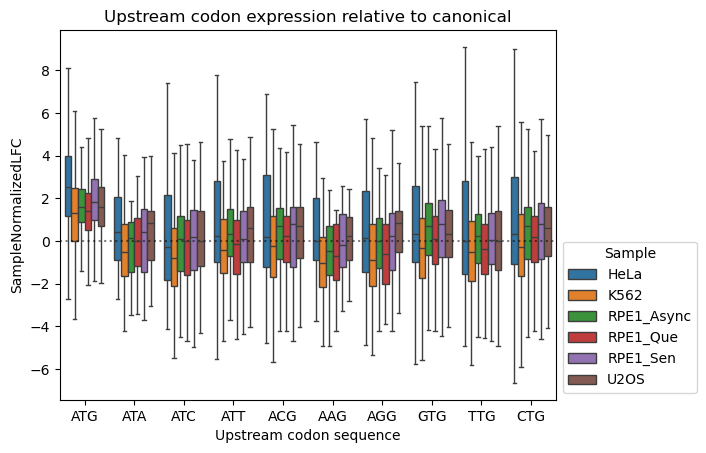

In [185]:
sns.boxplot(
    mane_select_paired_tis_df[mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='StartCodon', y='SampleNormalizedLFC', hue='Sample', showfliers=False,
    order=codon_order
)
plt.gca().axhline(0, linestyle='dotted', color='black', alpha=0.5)
plt.title('Upstream codon expression relative to canonical')
plt.xlabel('Upstream codon sequence')
plt.gca().get_legend().set_loc('lower left')
plt.gca().get_legend().set_bbox_to_anchor((1, 0))

# Relative translation conditional on UTR length / distance between upstream vs. canonical

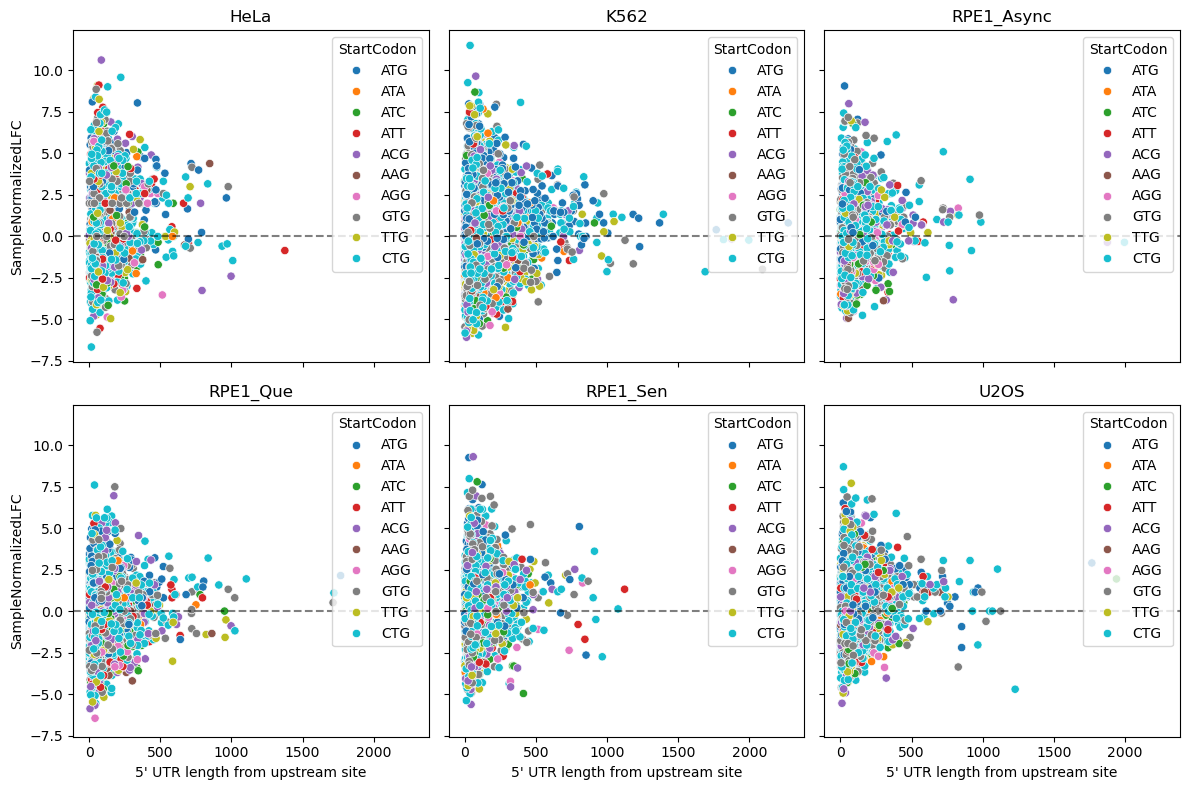

In [197]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s)
        ],
        x='Start', y='SampleNormalizedLFC', hue='StartCodon', hue_order=codon_order,
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s)
    axs[i].set_xlabel("5' UTR length from upstream site")

plt.tight_layout()
plt.show()

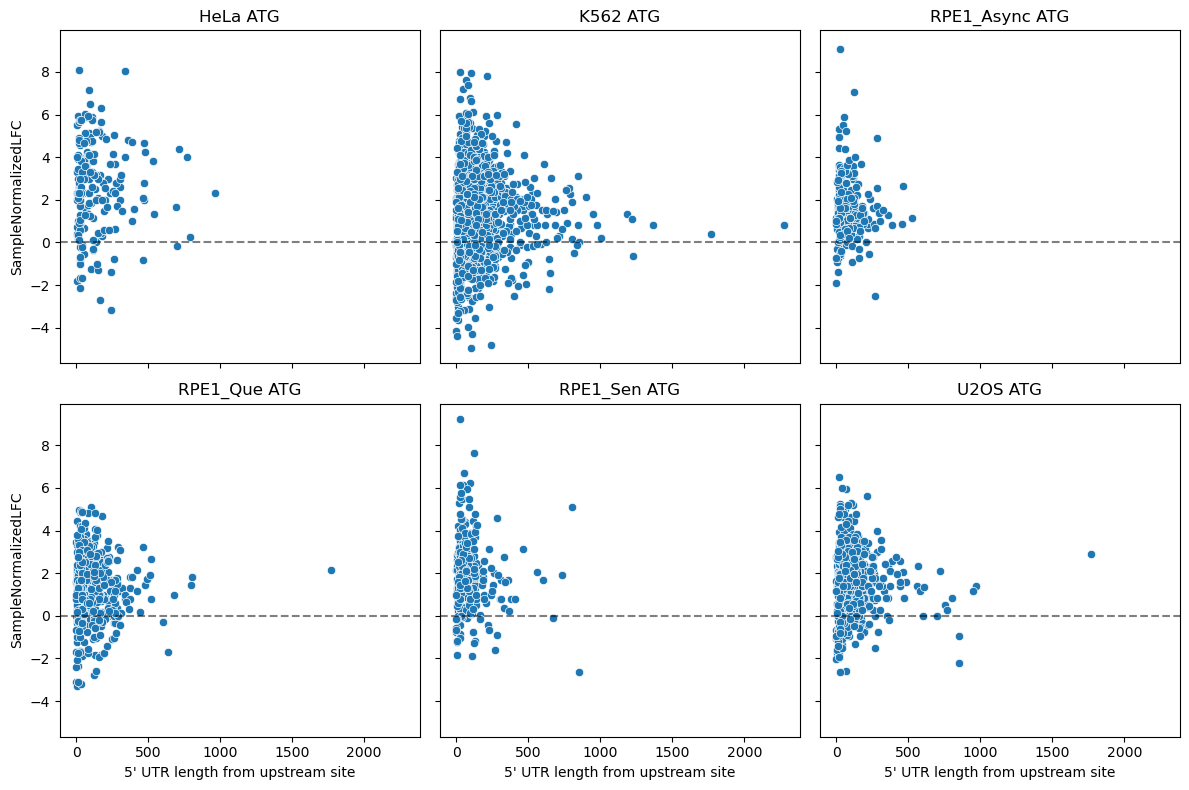

In [196]:
# control for start codon
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s) &
            (mane_select_paired_tis_df['StartCodon'] == 'ATG')
        ],
        x='Start', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s + ' ATG')
    axs[i].set_xlabel("5' UTR length from upstream site")

plt.tight_layout()
plt.show()

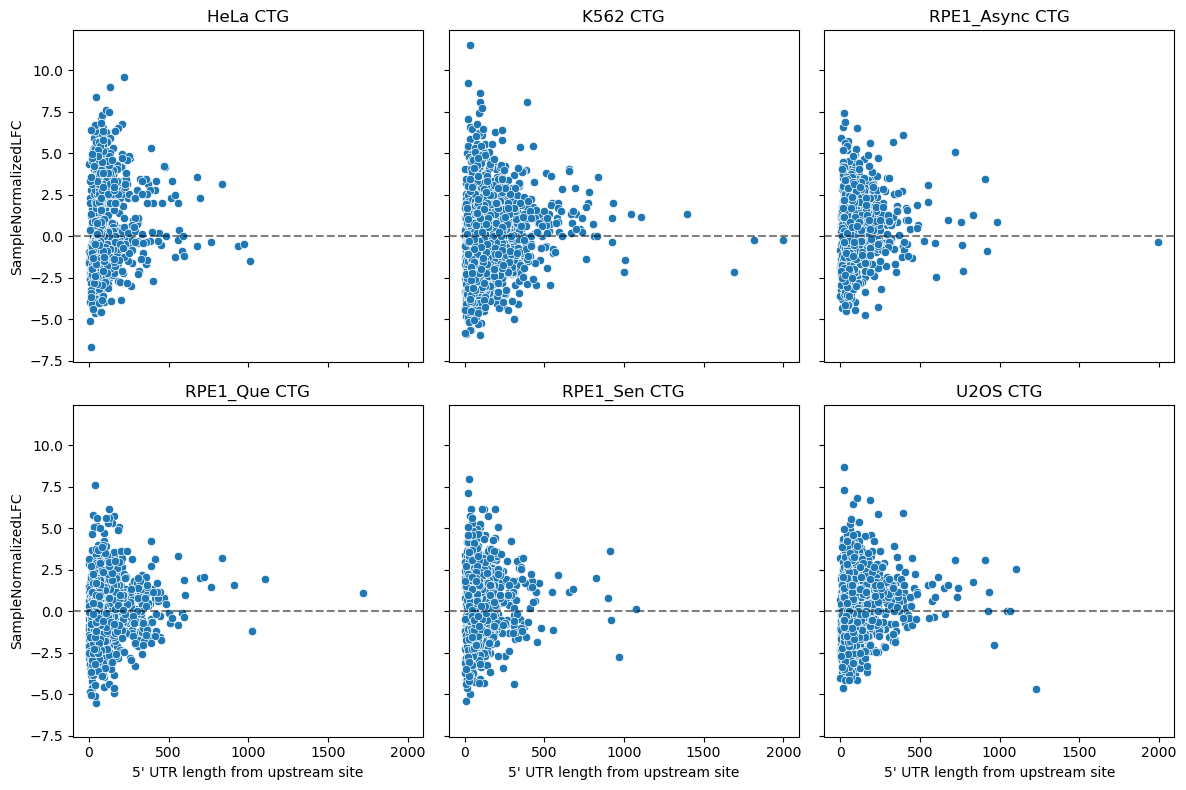

In [198]:
# control for start codon
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s) & 
            (mane_select_paired_tis_df['StartCodon'] == 'CTG')
        ],
        x='Start', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s + ' CTG')
    axs[i].set_xlabel("5' UTR length from upstream site")

plt.tight_layout()
plt.show()

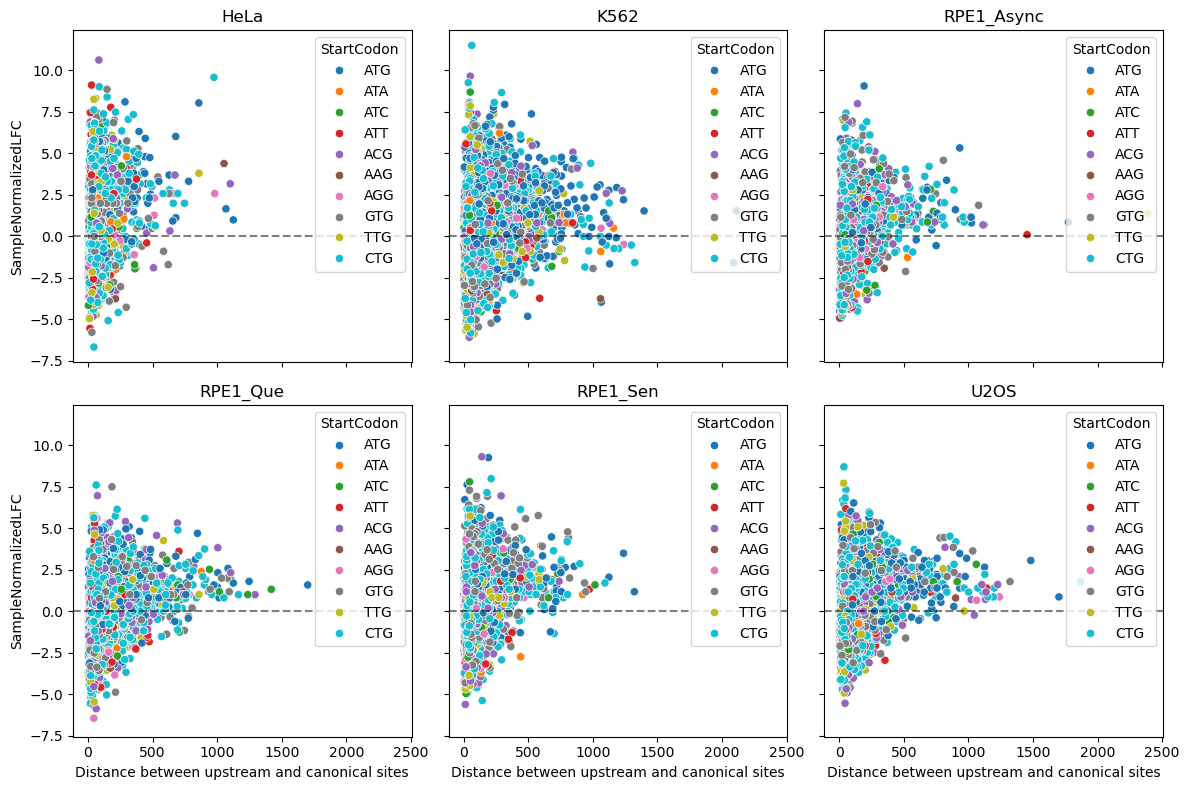

In [202]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s)
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC', hue='StartCodon', hue_order=codon_order,
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s)
    axs[i].set_xlabel("Distance between upstream and canonical sites")

plt.tight_layout()
plt.show()

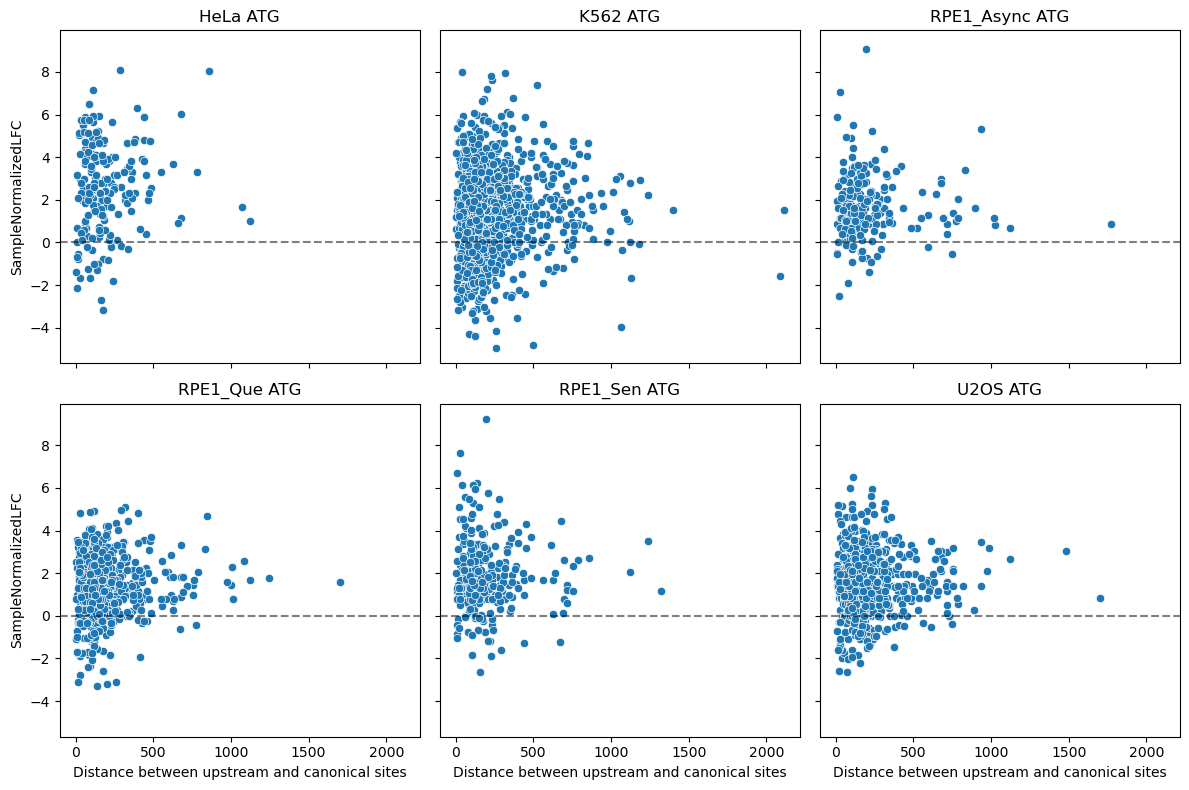

In [208]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s) & 
            (mane_select_paired_tis_df['StartCodon'] == 'ATG')
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s + ' ATG')
    axs[i].set_xlabel("Distance between upstream and canonical sites")

plt.tight_layout()
plt.show()

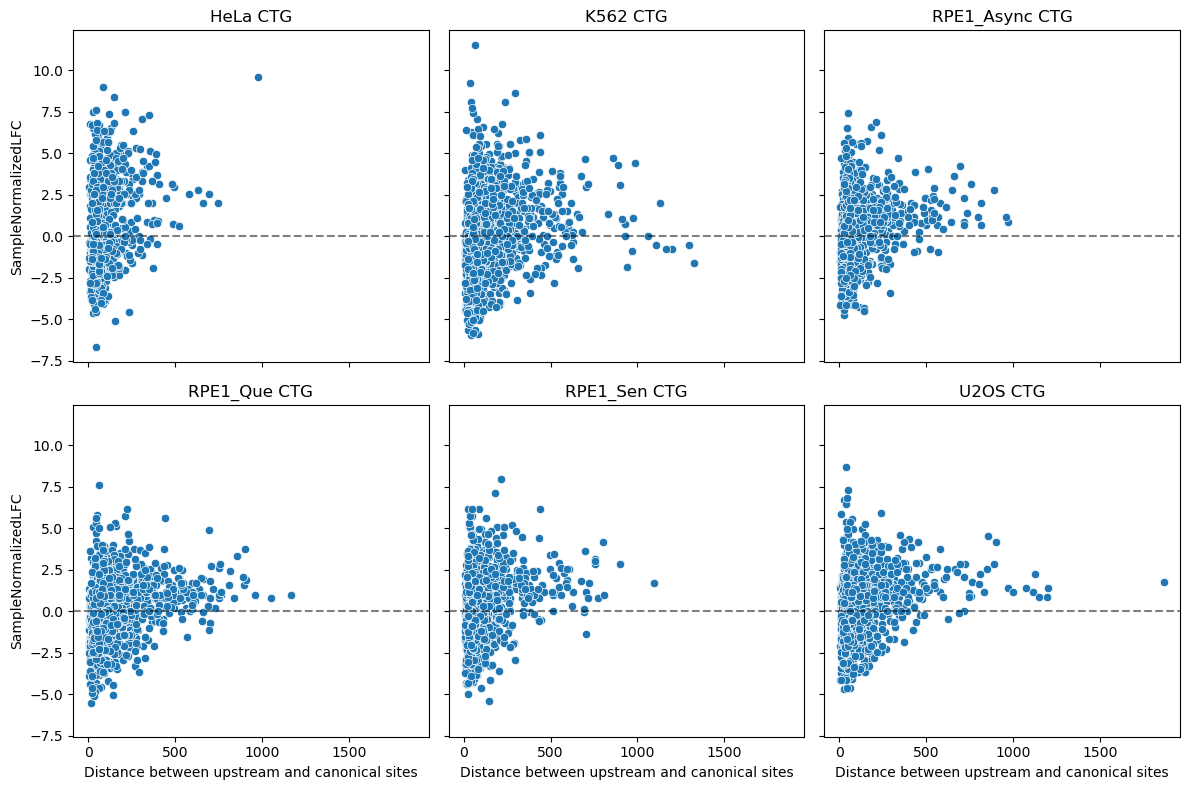

In [209]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, s in enumerate(samples):
    sns.scatterplot(
        mane_select_paired_tis_df[
            mane_select_paired_tis_df['RecatTISType'].isin(['Extended', 'uORF']) &
            (mane_select_paired_tis_df['Sample'] == s) & 
            (mane_select_paired_tis_df['StartCodon'] == 'CTG')
        ].assign(DistanceToCanonicalBP = lambda x: x['CanonicalStart'] - x['Start']),
        x='DistanceToCanonicalBP', y='SampleNormalizedLFC',
        ax=axs[i]
    )
    axs[i].axhline(0, linestyle='dashed', color='black', alpha=0.5)
    axs[i].set_title(s + ' CTG')
    axs[i].set_xlabel("Distance between upstream and canonical sites")

plt.tight_layout()
plt.show()